HIYU LOOP:   0%|          | 0/1 [00:00<?, ?it/s]

TRI LOOP: 0it [00:00, ?it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:   8%|▊         | 78/1000 [00:00<00:01, 766.87it/s]


SIM_LOOP:  16%|█▌        | 156/1000 [00:00<00:01, 770.07it/s]


SIM_LOOP:  23%|██▎       | 227/1000 [00:00<00:01, 749.93it/s]


SIM_LOOP:  28%|██▊       | 285/1000 [00:00<00:01, 689.05it/s]


SIM_LOOP:  37%|███▋      | 373/1000 [00:00<00:00, 735.33it/s]


SIM_LOOP:  45%|████▌     | 451/1000 [00:00<00:00, 747.12it/s]


SIM_LOOP:  53%|█████▎    | 529/1000 [00:00<00:00, 754.42it/s]


SIM_LOOP:  61%|██████    | 612/1000 [00:00<00:00, 774.28it/s]


SIM_LOOP:  69%|██████▉   | 692/1000 [00:00<00:00, 779.91it/s]


SIM_LOOP:  77%|███████▋  | 768/1000 [00:01<00:00, 764.73it/s]


SIM_LOOP:  86%|████████▌ | 857/1000 [00:01<00:00, 796.12it/s]


SIM_LOOP:  94%|█████████▎| 936/1000 [00:01<00:00, 753.54it/s]


                                                             

TRI LOOP: 1it [00:01,  1.63s/it]


S

SIM_LOOP:   8%|▊         | 76/1000 [00:00<00:01, 756.54it/s]


SIM_LOOP:  14%|█▍        | 140/1000 [00:00<00:01, 716.44it/s]


SIM_LOOP:  20%|██        | 200/1000 [00:00<00:01, 676.51it/s]


SIM_LOOP:  27%|██▋       | 274/1000 [00:00<00:01, 692.17it/s]


SIM_LOOP:  35%|███▍      | 346/1000 [00:00<00:00, 698.90it/s]


SIM_LOOP:  41%|████      | 410/1000 [00:00<00:00, 678.12it/s]


SIM_LOOP:  48%|████▊     | 484/1000 [00:00<00:00, 693.82it/s]


SIM_LOOP:  56%|█████▌    | 556/1000 [00:00<00:00, 700.09it/s]


SIM_LOOP:  64%|██████▎   | 636/1000 [00:00<00:00, 727.11it/s]


SIM_LOOP:  71%|███████   | 707/1000 [00:01<00:00, 719.49it/s]


SIM_LOOP:  78%|███████▊  | 778/1000 [00:01<00:00, 713.14it/s]


SIM_LOOP:  85%|████████▍ | 849/1000 [00:01<00:00, 708.54it/s]


SIM_LOOP:  92%|█████████▎| 925/1000 [00:01<00:00, 721.86it/s]


                                                             

TRI LOOP: 8it [00:14,  1.94s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:   9%|▉  

SIM_LOOP:   8%|▊         | 75/1000 [00:00<00:01, 749.45it/s]


SIM_LOOP:  18%|█▊        | 178/1000 [00:00<00:01, 813.76it/s]


SIM_LOOP:  27%|██▋       | 269/1000 [00:00<00:00, 833.15it/s]


SIM_LOOP:  35%|███▍      | 346/1000 [00:00<00:00, 812.02it/s]


SIM_LOOP:  43%|████▎     | 431/1000 [00:00<00:00, 819.98it/s]


SIM_LOOP:  53%|█████▎    | 526/1000 [00:00<00:00, 853.55it/s]


SIM_LOOP:  63%|██████▎   | 627/1000 [00:00<00:00, 894.51it/s]


SIM_LOOP:  73%|███████▎  | 727/1000 [00:00<00:00, 922.91it/s]


SIM_LOOP:  82%|████████▏ | 816/1000 [00:00<00:00, 902.27it/s]


SIM_LOOP:  91%|█████████▏| 913/1000 [00:01<00:00, 921.53it/s]


                                                             

TRI LOOP: 16it [00:26,  1.50s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:   9%|▉         | 93/1000 [00:00<00:00, 919.29it/s]


SIM_LOOP:  19%|█▉        | 191/1000 [00:00<00:00, 935.42it/s]


SIM_LOOP:  28%|██▊       | 283/1000 [00:00<00:00, 927.74it/s]


SIM_LOOP:  35%|███

SIM_LOOP:  94%|█████████▎| 936/1000 [00:01<00:00, 857.87it/s]


                                                             

TRI LOOP: 24it [00:38,  1.52s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:   8%|▊         | 82/1000 [00:00<00:01, 818.68it/s]


SIM_LOOP:  16%|█▌        | 159/1000 [00:00<00:01, 801.69it/s]


SIM_LOOP:  24%|██▎       | 236/1000 [00:00<00:00, 788.83it/s]


SIM_LOOP:  32%|███▏      | 317/1000 [00:00<00:00, 792.11it/s]


SIM_LOOP:  39%|███▉      | 393/1000 [00:00<00:00, 780.99it/s]


SIM_LOOP:  47%|████▋     | 470/1000 [00:00<00:00, 777.41it/s]


SIM_LOOP:  55%|█████▍    | 545/1000 [00:00<00:00, 768.95it/s]


SIM_LOOP:  62%|██████▏   | 624/1000 [00:00<00:00, 773.46it/s]


SIM_LOOP:  70%|██████▉   | 699/1000 [00:00<00:00, 764.96it/s]


SIM_LOOP:  78%|███████▊  | 775/1000 [00:01<00:00, 760.37it/s]


SIM_LOOP:  85%|████████▍ | 849/1000 [00:01<00:00, 744.83it/s]


SIM_LOOP:  93%|█████████▎| 926/1000 [00:01<00:00, 750.80it/s]


                 

                                                             

TRI LOOP: 32it [00:51,  1.62s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  12%|█▏        | 120/1000 [00:00<00:00, 1185.29it/s]


SIM_LOOP:  24%|██▍       | 238/1000 [00:00<00:00, 1180.22it/s]


SIM_LOOP:  35%|███▌      | 354/1000 [00:00<00:00, 1170.79it/s]


SIM_LOOP:  46%|████▌     | 461/1000 [00:00<00:00, 1136.30it/s]


SIM_LOOP:  56%|█████▋    | 563/1000 [00:00<00:00, 1096.60it/s]


SIM_LOOP:  67%|██████▋   | 669/1000 [00:00<00:00, 1081.68it/s]


SIM_LOOP:  77%|███████▋  | 772/1000 [00:00<00:00, 1065.60it/s]


SIM_LOOP:  88%|████████▊ | 875/1000 [00:00<00:00, 1052.96it/s]


SIM_LOOP:  97%|█████████▋| 974/1000 [00:00<00:00, 992.40it/s] 


                                                             

TRI LOOP: 33it [00:52,  1.53s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  11%|█▏        | 113/1000 [00:00<00:00, 1118.69it/s]


SIM_LOOP:  21%|██        | 212/1000 [00:00<00:

                                                             

TRI LOOP: 38it [01:06,  2.44s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:   7%|▋         | 69/1000 [00:00<00:01, 683.77it/s]


SIM_LOOP:  10%|█         | 102/1000 [00:00<00:01, 514.12it/s]


SIM_LOOP:  13%|█▎        | 131/1000 [00:00<00:02, 417.28it/s]


SIM_LOOP:  21%|██▏       | 213/1000 [00:00<00:01, 489.36it/s]


SIM_LOOP:  30%|███       | 304/1000 [00:00<00:01, 566.67it/s]


SIM_LOOP:  40%|███▉      | 399/1000 [00:00<00:00, 643.74it/s]


SIM_LOOP:  50%|█████     | 500/1000 [00:00<00:00, 720.05it/s]


SIM_LOOP:  61%|██████    | 611/1000 [00:00<00:00, 804.81it/s]


SIM_LOOP:  70%|███████   | 704/1000 [00:00<00:00, 834.77it/s]


SIM_LOOP:  80%|████████  | 803/1000 [00:01<00:00, 874.28it/s]


SIM_LOOP:  90%|█████████ | 902/1000 [00:01<00:00, 905.87it/s]


SIM_LOOP: 100%|██████████| 1000/1000 [00:01<00:00, 926.02it/s]


                                                              

TRI LOOP: 39it [

SIM_LOOP:  67%|██████▋   | 669/1000 [00:01<00:00, 612.58it/s]


SIM_LOOP:  78%|███████▊  | 782/1000 [00:01<00:00, 709.42it/s]


SIM_LOOP:  87%|████████▋ | 872/1000 [00:01<00:00, 757.08it/s]


SIM_LOOP:  99%|█████████▊| 986/1000 [00:01<00:00, 839.85it/s]


                                                             

TRI LOOP: 45it [01:22,  2.24s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:   9%|▉         | 92/1000 [00:00<00:00, 917.31it/s]


SIM_LOOP:  14%|█▍        | 143/1000 [00:00<00:01, 738.17it/s]


SIM_LOOP:  20%|█▉        | 196/1000 [00:00<00:01, 659.99it/s]


SIM_LOOP:  28%|██▊       | 281/1000 [00:00<00:01, 707.14it/s]


SIM_LOOP:  38%|███▊      | 376/1000 [00:00<00:00, 765.80it/s]


SIM_LOOP:  44%|████▍     | 442/1000 [00:00<00:00, 706.80it/s]


SIM_LOOP:  51%|█████     | 507/1000 [00:00<00:00, 656.21it/s]


SIM_LOOP:  58%|█████▊    | 577/1000 [00:00<00:00, 667.22it/s]


SIM_LOOP:  64%|██████▍   | 642/1000 [00:00<00:00, 622.09it/s]


SIM_LOOP:  71%|██

SIM_LOOP:  45%|████▍     | 447/1000 [00:00<00:00, 570.00it/s]


SIM_LOOP:  50%|█████     | 504/1000 [00:00<00:00, 549.90it/s]


SIM_LOOP:  56%|█████▌    | 559/1000 [00:01<00:00, 525.18it/s]


SIM_LOOP:  62%|██████▏   | 617/1000 [00:01<00:00, 539.02it/s]


SIM_LOOP:  69%|██████▉   | 688/1000 [00:01<00:00, 580.43it/s]


SIM_LOOP:  75%|███████▌  | 754/1000 [00:01<00:00, 601.75it/s]


SIM_LOOP:  83%|████████▎ | 832/1000 [00:01<00:00, 644.37it/s]


SIM_LOOP:  90%|█████████ | 900/1000 [00:01<00:00, 652.69it/s]


SIM_LOOP:  98%|█████████▊| 976/1000 [00:01<00:00, 679.95it/s]


                                                             

TRI LOOP: 53it [01:36,  1.80s/it]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  10%|▉         | 97/1000 [00:00<00:00, 963.29it/s]


SIM_LOOP:  18%|█▊        | 184/1000 [00:00<00:00, 928.24it/s]


SIM_LOOP:  28%|██▊       | 277/1000 [00:00<00:00, 926.87it/s]


SIM_LOOP:  36%|███▌      | 360/1000 [00:00<00:00, 895.46it/s]


SIM_LOOP:  45%|██

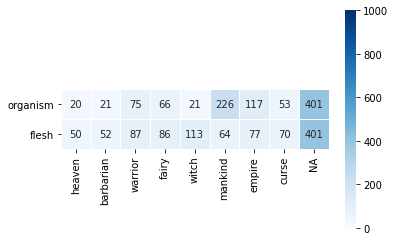

In [1]:
# %load "analysis.py"
from data_load import *
from common import identity_morphism
from graph_show import *
from my_function import *
from tri_established_coslice_simulator import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pygraphviz as pyg
import pprint
import math
from scipy.stats import pearsonr,spearmanr

# 連想強度をヒートマップで表示・出力する関数
#def adj_matrix(w2v_seed,source, target):
def adj_matrix(target,source):    

    #全てのイメージのデータを取得する
    node_data = get_node_data()
    
    assoc_net = make_assoc_net(source = "source", target = "target")


    A_node_data = sort_cossim_data(target)
    B_node_data = sort_cossim_data(source)
    A_node_data = A_node_data[1]
    B_node_data = B_node_data[1]
    A_node_data = A_node_data.tolist()
    B_node_data = B_node_data.tolist()
    A_node_data.remove(target)
    B_node_data.remove(source)

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data:
            if assoc_net.has_edge(B_node,A_node):
                weight = assoc_net[B_node][A_node]["weight"]
            else:
                weight = 0.0
            row.append(weight)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data)
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.savefig("./heatmap/nt_weight_"+target+"_"+source,bbox_inches="tight")


# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
#def object_TINT_edge_correspondence_heatmap(w2v_seed, source, target):
def object_TINT_edge_correspondence_heatmap(target,source):
    
    Corr_DIR = "./object_edge_correspondence/"


    #全てのイメージのデータを取得する
#    node_data = get_node_data(w2v_seed)
    node_data = get_node_data()
    weights = [0.05, 0.275, 0.5, 0.725, 0.95] # 0.05から0.225刻みの線形

    assoc_net = make_assoc_net(source="source",target="target")

    df_edge_corr = pd.read_csv(Corr_DIR+"Date_all_seed_6000_{}_{}_full_anti_1_iter_1000_correspondence.tsv".format(target,source),header=0,encoding="utf-8", sep="\t")
    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = list(node_data[node_data[0]==target][1])
    B_node_data = list(node_data[node_data[0]==source][1])
    A_node_data.remove(target)
    B_node_data.remove(source)
    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}

    for B_node in B_node_data:
        corr_A_nodes = df_edge_corr[df_edge_corr["B_cod"]==B_node]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            row.append(edge_corr_dict[(B_node,A_node)])
        matrix.append(row)

    
    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True, fmt="d")
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    # plt.savefig("nt_weight_"+A_name+"_"+B_name+".pdf")
    plt.savefig("./heatmap/object_edge_correspondence_count_"+target+"_"+source+".pdf")
    # plt.savefig("word2vec_edge_corr_count_"+A_name+"_"+B_name+".png")
     
# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
#def tri_TINT_edge_correspondence_heatmap(w2v_seed, source, target, tri_dom, tri_cod):
def tri_TINT_edge_correspondence_heatmap(target,source, tri_dom, tri_cod):
    Corr_DIR = "./tri_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    is_fill_graph = False

    df_edge_corr = pd.read_csv(Corr_DIR+"FOREDGE_Date_all_seed_6000_{}_{}_{}_{}_forced_anti_1_iter_1000_correspondence.tsv".format(target,source,tri_dom,tri_cod),header=0,encoding="utf-8", sep="\t")

    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = sort_cossim_data(target)
    A_node_data = A_node_data[1]
    A_node_data = A_node_data.tolist()
    A_node_data.remove(target)
    if is_fill_graph:
        B_node_data = sort_cossim_data(source)
        B_node_data = B_node_data[1]
        B_node_data = B_node_data.tolist()
        B_node_data.remove(source)
    else:
        B_node_data = [tri_dom,tri_cod] 


    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}
    for B_node in B_node_data:            
        corr_A_nodes = df_edge_corr[(df_edge_corr["B_cod"]==B_node) & (df_edge_corr["B_dom"] == source)]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            if (B_node,A_node) in edge_corr_dict:
                count = edge_corr_dict[(B_node,A_node)]
            else:
                count = 0
            row.append(count)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True,fmt="d",square=True)
    plt.ylim(0,len(B_node_data))
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/tri_edge_correspondence_count_{}_{}_{}_{}".format(target,source,tri_dom,tri_cod),bbox_inches="tight")

def human_correspondence_heatmap(target,source):
    human_corr_data = pd.read_csv("./human_correspondence/human_correspondence.csv",header=0,index_col=0)
    human_corr_data = human_corr_data.rename(columns={"舞う":"dance","飛ぶ":"fly","花":"flower","女性":"woman","空":"sky","美しさ":"beauty","儚さ":"empty",
                                "羽":"feather"},index={"踊り":"dance","女性":"woman","スカート":"skirt","夜":"night","音楽":"music","回る":"spin",
                                                      "揺れる":"shake","舞台":"stage"})
    plt.clf()
    sns.heatmap(human_corr_data,vmin=1.0,vmax=5.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/human_correspondence_{}_{}.pdf".format(target,source))


# TINTの対象同士のシミュレーション結果の対応づけを行列形式に整形する
def load_object_correspondence_data(fname,target,source):
    Corr_DIR = "./object_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()
    df_edge_corr = pd.read_csv(Corr_DIR+fname,header=0,encoding="utf-8",sep="\t")

    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = list(node_data[node_data[0]==target][1])
    B_node_data = list(node_data[node_data[0]==source][1])
    A_node_data.remove(target)
    B_node_data.remove(source)
    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}

    for B_node in B_node_data:
        corr_A_nodes = df_edge_corr[df_edge_corr["B_cod"]==B_node]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            row.append(edge_corr_dict[(B_node,A_node)])
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    return df

# 対象同士のTINTのシミュレーションの対応づけと、人間の対応づけの相関係数を計算し、ファイルに吐き出す
def human_object_data_correlation_to_csv(TINT_corr_fname,target,source,r_function=pearsonr):
    TINT_corr_data = load_object_correspondence_data(TINT_corr_fname,target,source)
    human_corr_data = pd.read_csv("./human_correspondence/human_correspondence.csv",header=0,index_col=0)
    human_corr_data = human_corr_data.rename(columns={"舞う":"dance","飛ぶ":"fly","花":"flower","女性":"woman","空":"sky","美しさ":"beauty","儚さ":"empty",
                                "羽":"feather"},index={"踊り":"dance","女性":"woman","スカート":"skirt","夜":"night","音楽":"music","回る":"spin",
                                                      "揺れる":"shake","舞台":"stage"})
    S_images = list(human_corr_data.index)
    save_dir = "./corref/"
    mtx = []
    for S_image in S_images:
        TINT_row = TINT_corr_data.loc[S_image]
        human_row = human_corr_data.loc[S_image]
        corref, p_value = r_function(list(human_row),list(TINT_row))#ピアソンの相関係数とp値
        mtx.append((S_image,corref,p_value))
    df = pd.DataFrame(mtx,columns=("S_image", "correlation","p_value"))
    df.to_csv(save_dir+"human_object_TINT_{}_correlation.tsv".format(r_function.__name__),sep="\t")  

# 全ての三角構造同士のシミュレーションの対応づけと、人間の対応づけの相関係数を計算し、ファイルに吐き出す
def human_tri_data_correlation_to_csv(target,source,seed,r_function=pearsonr):
    Corr_DIR = "./tri_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    # 人間のデータを読み込み
    # TODO:ここで人間のデータhuman_corrspondence.csvを読み込む

    human_corr_data = pd.read_csv("./human_correspondence/human_correspondence.csv",header=0,index_col=0)
    human_corr_data = human_corr_data.rename(columns={"舞う":"dance","飛ぶ":"fly","花":"flower","女性":"woman","空":"sky","美しさ":"beauty","儚さ":"empty",
                                "羽":"feather"},index={"踊り":"dance","女性":"woman","スカート":"skirt","夜":"night","音楽":"music","回る":"spin",
                                                      "揺れる":"shake","舞台":"stage"})

    # 三角構造同士の対応づけを読み込み
    tri_corr_data = pd.read_csv(Corr_DIR+"seed_{}_{}_{}_all_triangle_correspondence.tsv".format(seed,target,source),header=0,index_col=0,encoding="utf-8",sep="\t")

    T_images = list(node_data[node_data[0]=="butterfly"][1])
    T_images.remove("butterfly")
    T_images.append("NA")
    S_images = list(node_data[node_data[0]=="dancer"][1])
    S_images.remove("dancer")

    tri_human_corrcef_list = []
    tri_human_corrcef_all_image_list = []
    tri_human_p_value_list = []
    for idx in range(0,len(tri_corr_data),2):
        first_image = T_images[0]
        TINT_row1 = np.array(tri_corr_data.loc[idx,first_image:],dtype=float)       #コスライス圏の射のdomの対応行
        TINT_row2 = np.array(tri_corr_data.loc[idx+1,first_image:],dtype=float)     #コスライス圏の射のcodの対応行
        tri_dom = tri_corr_data["dom/cod"][idx]  #コスライス圏のdom
        tri_cod = tri_corr_data["dom/cod"][idx+1]  #コスライス圏のcod

        human_row1 = np.array(human_corr_data.loc[tri_dom][:],dtype=float)
        human_row2 = np.array(human_corr_data.loc[tri_dom][:],dtype=float)
        if len(TINT_row1) != 9 or len(TINT_row2) != 9 or len(human_row1) != 9 or len(human_row2)!=9:
            print("data format error: row is 9 col")
        # 相関係数を計算するときにfloat関係でエラー出ることがあるその際はdtypeを明示的にfloatに変更すること
        # 三角構造を構成するイメージのTINTの対応づけとそのイメージの人間の対応づけの相関を計算
        dom_corref = 0
        cod_corref = 0
        dom_p = 0
        cod_p = 0
        corref_list1 = []
        corref_list2 = []
        p_value_list1 = []
        p_value_list2 = []
        for idx,human_row in human_corr_data.iterrows():
            row1_corr,r1_p = r_function(np.array(human_row,dtype=float),TINT_row1)
            row2_corr,r2_p = r_function(np.array(human_row,dtype=float),TINT_row2)

            if tri_dom == idx:
                dom_corref = row1_corr
                dom_p = r1_p
            if tri_cod == idx:
                cod_corref = row2_corr
                cod_p = r2_p

            corref_list1.append(row1_corr)
            corref_list2.append(row2_corr)
            p_value_list1.append(r1_p)
            p_value_list2.append(r2_p)

        tri_human_corrcef_list.append(
            [tri_dom, tri_cod, dom_corref, cod_corref, dom_p, cod_p]
        )
        tri_human_corrcef_all_image_list.append([(tri_dom,tri_cod),tri_dom] + corref_list1)
        tri_human_corrcef_all_image_list.append([(tri_dom,tri_cod),tri_cod] + corref_list2)
        tri_human_p_value_list.append([(tri_dom,tri_cod),tri_dom] + p_value_list1)
        tri_human_p_value_list.append([(tri_dom,tri_cod),tri_cod] + p_value_list2)

    # 同じ対象の対応づけの傾向の相関係数をファイルへ
    df = pd.DataFrame(tri_human_corrcef_list,columns=("dom","cod","dom_correlation","cod_correlation","dom_p","cod_p"))
    df.to_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),sep="\t")

    # １つの対象の対応づけの傾向に対して人間の8つの対象の対応づけの傾向との相関係数をファイルへ
    df = pd.DataFrame(tri_human_corrcef_all_image_list,columns=(["tri_edge","dom/cod"] + S_images))
    df.to_csv("./corref/human_tri_data_{}_correlation_all_images.tsv".format(r_function.__name__),sep="\t")

    # １つの対象の対応づけの傾向に対して人間の8つの対象の対応づけの傾向との相関係数のp値をファイルへ
    df = pd.DataFrame(tri_human_p_value_list, columns=(["tri_edge","dom/cod"] + S_images))
    df.to_csv("./corref/human_tri_data_{}_p_value_all_images.tsv".format(r_function.__name__),sep="\t")


# 人間と三角構造同士のTINTの相関のうち閾値を超えているものを表示
def tri_correlation_analysis_over_th(r_function=spearmanr,corref_th = 0.4):
    # 人間の対応と、三角構造のTINTの対応づけとの相関データを取り出す
    tri_corref = pd.read_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")
    tri_corref_over_th = tri_corref[(tri_corref["dom_correlation"] >= corref_th) & (tri_corref["cod_correlation"] >= corref_th)]
    tri_corref_over_th = tri_corref_over_th.assign(order = lambda df: df.dom_correlation + df.cod_correlation)
    tri_corref_over_th.sort_values("order",ascending=False)
    print("相関がどちらも{}以上の三角構造({}個)".format(corref_th,len(tri_corref_over_th)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for idx,row in tri_corref_over_th.iterrows():
        dom, cod = row["dom"], row["cod"]
        dom_corr = row["dom_correlation"]
        cod_corr = row["cod_correlation"]
        dom_p    = row["dom_p"]
        cod_p    = row["cod_p"]
        print("({:4} , {:4}) \t {} \t {} \t {} \t {}".format(dom,cod,round(dom_corr,2),round(cod_corr,2),round(dom_p,3),round(cod_p,3)))

# 人間と対象同士同士のTINTの相関のうち閾値を超えているものを表示
def object_correlation_analysis_over_th(r_function=pearsonr, corref_th = 0.4):
    # 人間の対応と、対象同士のTINTの対応づけとの相関データを取り出す
    object_corref = pd.read_csv("./corref/human_object_TINT_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")
    object_corref_over_th = object_corref[object_corref["correlation"] >= corref_th]
 
    print("相関がどちらも{}以上の三角構造".format(corref_th))
    print("image \t r \t p_value")
    for idx,row in object_corref_over_th.iterrows():
        S_image = row["S_image"]
        corref  = row["correlation"]
        p_value = row["p_value"]
        print("{} \t {} \t {}".format(S_image,round(corref,2),round(p_value,3)))

def compare_tri_and_object_correlation(r_function=pearsonr):
    object_corref = pd.read_csv("./corref/human_object_TINT_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=1,sep="\t")
    tri_corref = pd.read_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")

    is_over_corref_matrix = []
    is_less_corref_matrix = []

    for idx,row in tri_corref.iterrows():
        dom, cod = row["dom"], row["cod"]
        dom_tri_corr = row["dom_correlation"]
        cod_tri_corr = row["cod_correlation"]
        dom_p    = row["dom_p"]
        cod_p    = row["cod_p"]
        dom_obj_corr = float(object_corref.loc[dom,["correlation"]])
        cod_obj_corr = float(object_corref.loc[cod,["correlation"]])
        if dom_tri_corr > dom_obj_corr and cod_tri_corr > cod_obj_corr:
            is_over_corref_matrix.append((dom,cod,round(dom_tri_corr,2),round(cod_tri_corr,2),round(dom_p,3),round(cod_p,3),dom_tri_corr+cod_tri_corr))
        elif dom_tri_corr < dom_obj_corr and cod_tri_corr < cod_obj_corr:
            is_less_corref_matrix.append((dom,cod,round(dom_tri_corr,2),round(cod_tri_corr,2),round(dom_p,3),round(cod_p,3),dom_tri_corr+cod_tri_corr))

    is_over_corref_matrix = sorted(is_over_corref_matrix,key= lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を超えている三角構造({}個)".format(len(is_over_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,dom_corr,cod_corr,dom_p,cod_p,_ in is_over_corref_matrix:
        print("({:4} , {:4}) \t {} \t {} \t {} \t {}".format(dom,cod,dom_corr,cod_corr,dom_p,cod_p))

    is_less_corref_matrix = sorted(is_less_corref_matrix,key= lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を下回っている三角構造({}個)".format(len(is_less_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,dom_corr,cod_corr,dom_p,cod_p,_ in is_less_corref_matrix:
        print("({:4} , {:4}) \t {} \t {} \t {} \t {}".format(dom,cod,dom_corr,cod_corr,dom_p,cod_p))

def over_less_tri_and_object_assoc_prob_th(r_function=pearsonr):
    object_corref = pd.read_csv("./corref/human_object_TINT_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=1,sep="\t")
    tri_corref = pd.read_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")
   

    assoc_data = load_three_metaphor_data()
    assoc_net = nx.from_pandas_edgelist(df = assoc_data, source='source', target='target',edge_attr=["weight"], create_using=nx.DiGraph)
    identity_morphism(assoc_net)


    is_over_corref_matrix = []
    is_less_corref_matrix = []

    for idx,row in tri_corref.iterrows():
        dom, cod = row["dom"], row["cod"]
        dom_tri_corr = row["dom_correlation"]
        cod_tri_corr = row["cod_correlation"]
        dom_p    = row["dom_p"]
        cod_p    = row["cod_p"]
        dom_obj_corr = float(object_corref.loc[dom,["correlation"]])
        cod_obj_corr = float(object_corref.loc[cod,["correlation"]])
        if dom_tri_corr > dom_obj_corr and cod_tri_corr > cod_obj_corr:
            if assoc_net[dom][cod]["weight"] >= 0.75:
                is_over_corref_matrix.append((dom,cod,assoc_net[dom][cod]["weight"]))
        elif dom_tri_corr < dom_obj_corr and cod_tri_corr < cod_obj_corr:
            if assoc_net[dom][cod]["weight"] >= 0.75:
                is_less_corref_matrix.append((dom,cod,assoc_net[dom][cod]["weight"]))

    is_over_corref_matrix = sorted(is_over_corref_matrix,key=lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を超えている三角構造で射の連想確率が0.75を超えているもの({}個)".format(len(is_over_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,prob in is_over_corref_matrix:
        print("({:4} , {:4}) \t {} ".format(dom,cod,prob))

    is_less_corref_matrix = sorted(is_less_corref_matrix,key=lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を下回っている三角構造で射の連想確率が0.75を超えているもの({}個)".format(len(is_less_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,prob in is_less_corref_matrix:
        print("({:4} , {:4}) \t {} ".format(dom,cod,prob))
    
if __name__ == "__main__":
    # 連想確率、TINTのシミュレーション結果(対象同士、三角構造同士)、人間の比喩解釈データをヒートマップで出力する
    A = "lord"
    B = "human"
    all_tri_structure_established_three_metaphor_sim(A,B)
    adj_matrix(A,B)
    B_node_data = sort_cossim_data(B)
    B_node_data = B_node_data[1]
    B_node_data = B_node_data.tolist()
    B_node_data.remove(B)
    for dom, cod in iter.permutations(B_node_data,2):
        tri_TINT_edge_correspondence_heatmap(A,B,dom,cod)
 